# Predicting Cancer

In [2]:
# Import Libraries
import pandas as pd
import numpy as np

# Plotting
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import product
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
# ML
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score

In [3]:
# Load the dataset
file_path = 'wine.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [4]:
data = data.drop("Unnamed: 0",axis=1)

In [5]:
# Exchange Spaces for Underscore in Columns
def replace_space_with_underscore(df):
    """Replaces all spaces in column names with underscores.

    Args:
        df (pandas.DataFrame): The DataFrame to modify.

    Returns:
        pandas.DataFrame: The DataFrame with the modified column names.
    """

    new_column_names = []
    for column_name in df.columns:
        if " " in column_name:
            new_column_name = column_name.replace(" ", "_")
        else:
            new_column_name = column_name

        new_column_names.append(new_column_name)

    df.columns = new_column_names
    return df
data = replace_space_with_underscore(data)

In [6]:
data.type.unique()

array(['red', 'white'], dtype=object)

In [7]:
data.replace({"red": 1,"white":0}, inplace=True)

In [8]:
data.info()
# No null values!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


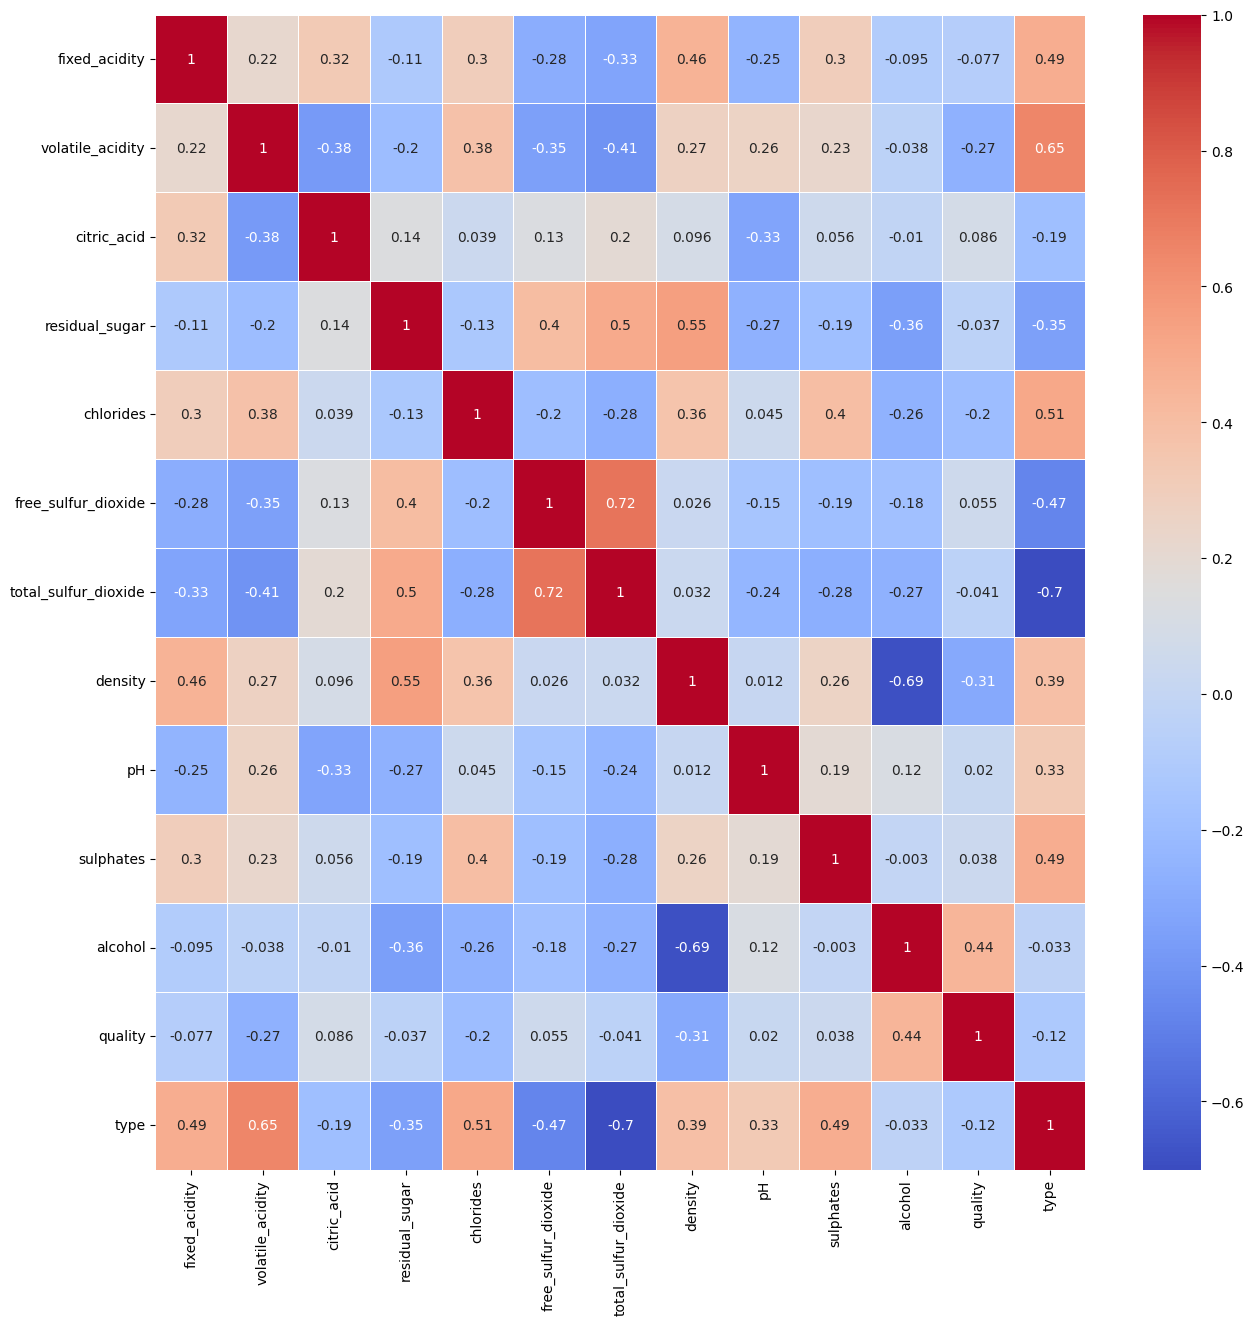

In [9]:
correlations = data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlations, annot = True, cmap ="coolwarm", linewidths = .5)
plt.show()

**Findings:** We observe a number of highly correlated features, namely: density & alchol (drop density)
We also see that more or less half of the features are highly correlated with the target value type

In [10]:
data = data.drop("density",axis=1)

In [11]:
# Create Target and Feature variables and split data into train and test
X = data.drop(columns=["type"], axis=1)
y = data["type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [12]:
# create dummy columns for categorical columns using OneHotEncoder

# find categorical columns
X_train_cat = X_train.select_dtypes(["int"])

# apply OHE to categorical columns
ohe = OneHotEncoder(sparse_output=False,handle_unknown='infrequent_if_exist')
cat_data_ohe = ohe.fit_transform(X_train_cat)
cat_data_ohe = pd.DataFrame(cat_data_ohe, columns=ohe.get_feature_names_out())

# join OHEed columns to the original X matrix
X_train_full = pd.concat([X_train.reset_index(drop=True), cat_data_ohe], axis=1)
X_train_full = X_train_full.drop(columns=X_train_cat.columns)

In [13]:
# Apply Scaler
scaler = StandardScaler()

X_train_full = scaler.fit_transform(X_train_full)

In [14]:
clf = LogisticRegression(solver='liblinear', max_iter=1000)

parameters = {
    'penalty': ['l2', 'l1'],
    'C': [0.01, 0.1, 1, 10],
}

search = RandomizedSearchCV(
    clf,                               # this is the instantiated estimator object, that is, the model we want to tune
    param_distributions=parameters,    # this is the predefinad search space
    scoring="roc_auc",                 # the metric we want the tuner calculates in order to select the best combination, roc_auc is usually the best sinc it is not sensitive to imbalanced data
    cv=3,                              # the cross-validation schema we want to use (same as in the "cross_validate" or "cross_val_score")
    refit=True,                        # if we want to fit again the model on the best hyp. setting found after the process
    n_jobs=-1,                         # this is to indicate the operative system to use all processor cores and speed up the process
    return_train_score=True,           # if we want the tuner also return the scores on training (not just in validation)
    n_iter=10                          # the number of attempts we want to perform, you can adjust this as needed
)


In [15]:
# Train Model
search.fit(X_train_full, y_train)

C:\Users\phili\anaconda3\envs\Python-1\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=1000,
                                                solver='liblinear'),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='roc_auc')

In [16]:
results = pd.DataFrame(search.cv_results_)
results = results.sort_values("mean_test_score", ascending=False)

In [17]:
# show the best 5 models
results.head().T

,3,0,2,4,1
mean_fit_time,0.020056,0.014886,0.011208,0.019579,0.008343
std_fit_time,0.007196,0.001504,0.008061,0.004911,0.006242
mean_score_time,0.006785,0.036391,0.008642,0.010601,0.022201
std_score_time,0.007052,0.004835,0.004966,0.007499,0.006945
param_penalty,l1,l2,l2,l2,l1
param_C,0.1,0.01,0.1,1,0.01
params,"{'penalty': 'l1', 'C': 0.1}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l2', 'C': 0.1}","{'penalty': 'l2', 'C': 1}","{'penalty': 'l1', 'C': 0.01}"
split0_test_score,0.997694,0.997681,0.997403,0.997179,0.997792
split1_test_score,0.995787,0.995187,0.995695,0.995861,0.994767
split2_test_score,0.995015,0.995385,0.995153,0.994753,0.995174


In [18]:
# create dummy columns for categorical columns using OneHotEncoder
# fing categorical columns
X_test_cat = X_test.select_dtypes(["int"])

# apply OHE to categorical columns
cat_data_ohe = ohe.transform(X_test_cat)
cat_data_ohe = pd.DataFrame(cat_data_ohe, columns=ohe.get_feature_names_out())

# join OHEed columns to the original X matrix
X_test_full = pd.concat([X_test.reset_index(drop=True), cat_data_ohe], axis=1)
X_test_full = X_test_full.drop(columns=X_test_cat.columns)

# apply stanrdadization also to the test
X_test_full = scaler.transform(X_test_full)

In [19]:
pred_test = search.predict(X_test_full)
probas_test = search.predict_proba(X_test_full)

In [20]:
# Evaluation Metrics
precision_test = precision_score(y_test, pred_test, pos_label=1)
recall_test = recall_score(y_test, pred_test, pos_label=1)
f1_test = f1_score(y_test, pred_test, pos_label=1)
roc_auc_test = roc_auc_score(y_test, probas_test[:,1])

print(f"Test Precision: {round(precision_test,3)}")
print(f"Test Recall: {round(recall_test,3)}")
print(f"Test F1: {round(f1_test,3)}")
print(f"Test ROC_AUC: {round(roc_auc_test,3)}")

Test Precision: 0.982
Test Recall: 0.967
Test F1: 0.975
Test ROC_AUC: 0.992


In [21]:
import pickle

# Your trained machine learning model
model = search

# Specify the file path to save the model
model_file_path = 'wine.pkl'

# Open the file in binary write mode
with open(model_file_path, 'wb') as model_file:
    pickle.dump(model, model_file)


In [22]:
import pickle

# Save the scaler as a pickle file
scaler_filename = "wine_scaler.pkl"
with open(scaler_filename, "wb") as f:
    pickle.dump(scaler, f)

In [24]:
# Find categorical columns
X_train_cat = X_train.select_dtypes(["int"])

# Apply OHE to categorical columns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist')
cat_data_ohe = ohe.fit_transform(X_train_cat)

# Create a DataFrame with new column names
cat_data_ohe_df = pd.DataFrame(cat_data_ohe, columns=ohe.get_feature_names_out(X_train_cat.columns))

# Concatenate OHEed columns with the original DataFrame
# Ensure to reset the index of X_train to align with the OHE DataFrame
X_train_full = pd.concat([X_train.reset_index(drop=True), cat_data_ohe_df], axis=1)

# Drop original categorical columns
X_train_full.drop(columns=X_train_cat.columns, inplace=True)


In [25]:
columns = []
for column in X_train_full:
    columns.append(column)

In [26]:
columns

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'pH',
 'sulphates',
 'alcohol',
 'quality_3',
 'quality_4',
 'quality_5',
 'quality_6',
 'quality_7',
 'quality_8',
 'quality_9']

In [27]:
columns = []
for column in X_train_full:
    print(column,",")

fixed_acidity ,
volatile_acidity ,
citric_acid ,
residual_sugar ,
chlorides ,
free_sulfur_dioxide ,
total_sulfur_dioxide ,
pH ,
sulphates ,
alcohol ,
quality_3 ,
quality_4 ,
quality_5 ,
quality_6 ,
quality_7 ,
quality_8 ,
quality_9 ,
